In [4]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from torch import nn, optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Ścieżki do plików i folderów
annotations_path = '/content/drive/My Drive/ProjektOwoce/data/annotations.json'
image_dir = '/content/drive/My Drive/ProjektOwoce/training'
test_dir = '/content/drive/My Drive/ProjektOwoce/testing'
predicted_annotations_path = '/content/drive/My Drive/ProjektOwoce/data/predicted_annotations.json'

# Lista klas owoców
class_names = ['Apple', 'Avocado', 'Kiwi', 'Lemon', 'Orange', 'Pear', 'Pineapple', 'Pomegranate', 'Strawberry']

# Transformacje dla obrazów
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Przygotowanie danych
class FruitDataset(Dataset):
    def __init__(self, annotations, image_dir, transform=None):
        self.annotations = annotations
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        image_path = os.path.join(self.image_dir, annotation['filename'])
        image = Image.open(image_path).convert("RGB")

        # Przygotowanie etykiety
        labels = [0] * len(class_names)
        for item in annotation['labels']:
            label = item['label']
            label_idx = class_names.index(label)
            labels[label_idx] = 1

        labels = torch.tensor(labels, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, labels

# Wczytanie pliku z anotacjami
with open(annotations_path, 'r') as f:
    annotations = json.load(f)

# Utworzenie zbioru danych i DataLoader
dataset = FruitDataset(annotations, image_dir, transform)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Załadowanie modelu ResNet18
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

# Funkcja straty i optymalizator
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Funkcja trenowania modelu
def train_model(model, train_loader, criterion, optimizer, num_epochs=30):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Trenowanie modelu
train_model(model, train_loader, criterion, optimizer, num_epochs=30)

# Testowanie i zapisywanie wyników
def test_and_save_predictions(model, test_dir, output_path):
    model.eval()
    image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith(('.jpg', '.png', '.jpeg'))]
    predictions = []

    for image_path in image_paths:
        image = Image.open(image_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0).to(device)

        # Przewidywanie
        with torch.no_grad():
            outputs = model(image_tensor)
            predicted_labels = torch.sigmoid(outputs) > 0.3

        # Przygotowanie wyników
        predicted_fruits = [class_names[i] for i in range(len(class_names)) if predicted_labels[0][i].item() == 1]
        predictions.append({
            'filename': os.path.basename(image_path),
            'predicted_labels': predicted_fruits
        })

    # Zapis wyników do pliku JSON
    with open(output_path, 'w') as f:
        json.dump(predictions, f, indent=4)
    print(f"Predictions saved to {output_path}")

# Testowanie i zapisywanie wyników
test_and_save_predictions(model, test_dir, predicted_annotations_path)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/30: 100%|██████████| 19/19 [04:29<00:00, 14.19s/batch]


Epoch 1/30, Loss: 0.3170


Epoch 2/30: 100%|██████████| 19/19 [01:33<00:00,  4.92s/batch]


Epoch 2/30, Loss: 0.2312


Epoch 3/30: 100%|██████████| 19/19 [01:32<00:00,  4.88s/batch]


Epoch 3/30, Loss: 0.2226


Epoch 4/30: 100%|██████████| 19/19 [01:36<00:00,  5.05s/batch]


Epoch 4/30, Loss: 0.2004


Epoch 5/30: 100%|██████████| 19/19 [01:33<00:00,  4.91s/batch]


Epoch 5/30, Loss: 0.1923


Epoch 6/30: 100%|██████████| 19/19 [01:36<00:00,  5.07s/batch]


Epoch 6/30, Loss: 0.1835


Epoch 7/30: 100%|██████████| 19/19 [01:33<00:00,  4.91s/batch]


Epoch 7/30, Loss: 0.1966


Epoch 8/30: 100%|██████████| 19/19 [01:36<00:00,  5.06s/batch]


Epoch 8/30, Loss: 0.1631


Epoch 9/30: 100%|██████████| 19/19 [01:33<00:00,  4.90s/batch]


Epoch 9/30, Loss: 0.1662


Epoch 10/30: 100%|██████████| 19/19 [01:36<00:00,  5.08s/batch]


Epoch 10/30, Loss: 0.1401


Epoch 11/30: 100%|██████████| 19/19 [01:32<00:00,  4.89s/batch]


Epoch 11/30, Loss: 0.1514


Epoch 12/30: 100%|██████████| 19/19 [01:36<00:00,  5.09s/batch]


Epoch 12/30, Loss: 0.1412


Epoch 13/30: 100%|██████████| 19/19 [01:33<00:00,  4.91s/batch]


Epoch 13/30, Loss: 0.1474


Epoch 14/30: 100%|██████████| 19/19 [01:36<00:00,  5.08s/batch]


Epoch 14/30, Loss: 0.1272


Epoch 15/30: 100%|██████████| 19/19 [01:32<00:00,  4.88s/batch]


Epoch 15/30, Loss: 0.1222


Epoch 16/30: 100%|██████████| 19/19 [01:34<00:00,  4.96s/batch]


Epoch 16/30, Loss: 0.1221


Epoch 17/30: 100%|██████████| 19/19 [01:33<00:00,  4.90s/batch]


Epoch 17/30, Loss: 0.1149


Epoch 18/30: 100%|██████████| 19/19 [01:36<00:00,  5.07s/batch]


Epoch 18/30, Loss: 0.1166


Epoch 19/30: 100%|██████████| 19/19 [01:33<00:00,  4.90s/batch]


Epoch 19/30, Loss: 0.1109


Epoch 20/30: 100%|██████████| 19/19 [01:35<00:00,  5.01s/batch]


Epoch 20/30, Loss: 0.1235


Epoch 21/30: 100%|██████████| 19/19 [01:35<00:00,  5.03s/batch]


Epoch 21/30, Loss: 0.0970


Epoch 22/30: 100%|██████████| 19/19 [01:34<00:00,  4.95s/batch]


Epoch 22/30, Loss: 0.0884


Epoch 23/30: 100%|██████████| 19/19 [01:37<00:00,  5.14s/batch]


Epoch 23/30, Loss: 0.0860


Epoch 24/30: 100%|██████████| 19/19 [01:34<00:00,  4.98s/batch]


Epoch 24/30, Loss: 0.0830


Epoch 25/30: 100%|██████████| 19/19 [01:36<00:00,  5.06s/batch]


Epoch 25/30, Loss: 0.0878


Epoch 26/30: 100%|██████████| 19/19 [01:33<00:00,  4.91s/batch]


Epoch 26/30, Loss: 0.0897


Epoch 27/30: 100%|██████████| 19/19 [01:36<00:00,  5.08s/batch]


Epoch 27/30, Loss: 0.0750


Epoch 28/30: 100%|██████████| 19/19 [01:33<00:00,  4.94s/batch]


Epoch 28/30, Loss: 0.0614


Epoch 29/30: 100%|██████████| 19/19 [01:36<00:00,  5.07s/batch]


Epoch 29/30, Loss: 0.0743


Epoch 30/30: 100%|██████████| 19/19 [01:33<00:00,  4.93s/batch]


Epoch 30/30, Loss: 0.0833
Predictions saved to /content/drive/My Drive/ProjektOwoce/data/predicted_annotations.json


Overall accuracy: 77.78%


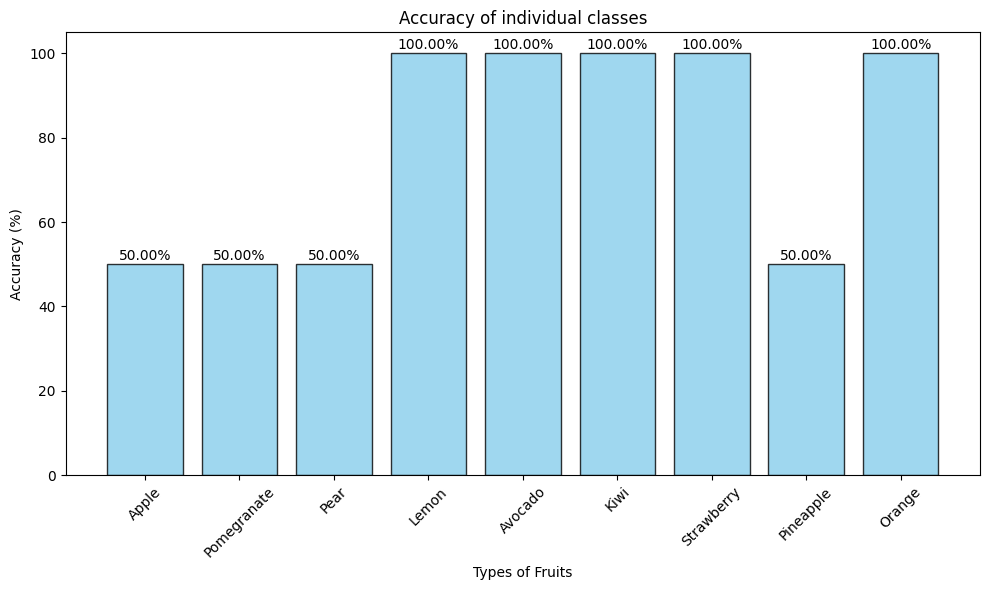

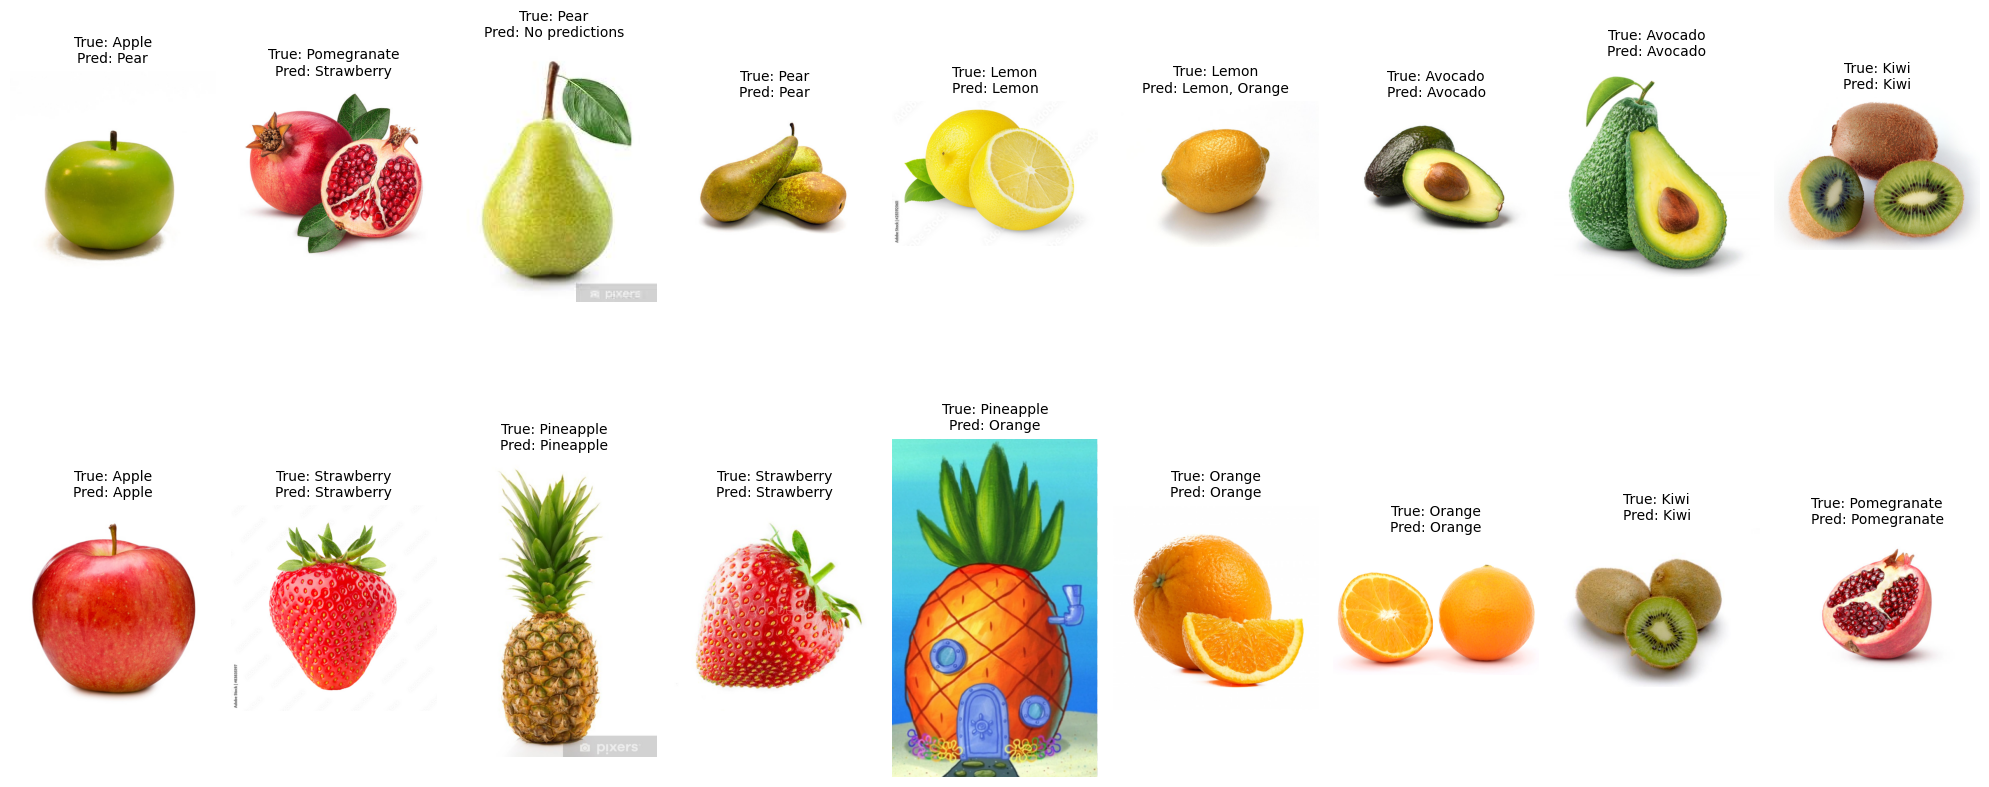

In [8]:
import os
import json
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from PIL import Image

# Ścieżki do plików
true_annotations_path = '/content/drive/My Drive/ProjektOwoce/data/true_annotations.json'
predicted_annotations_path = '/content/drive/My Drive/ProjektOwoce/data/predicted_annotations.json'
image_dir = '/content/drive/My Drive/ProjektOwoce/testing'

# Wczytanie danych
with open(true_annotations_path, 'r') as f:
    true_annotations = json.load(f)

with open(predicted_annotations_path, 'r') as f:
    predicted_annotations = json.load(f)

# Tworzenie mapy prawdziwych etykiet
true_labels_map = {item['filename']: set(item['labels']) for item in true_annotations}

# Analiza wyników
correct = 0
total = 0
class_correct = defaultdict(int)
class_total = defaultdict(int)

# Przechodzimy przez każde zdjęcie i porównujemy przewidywania z prawdziwymi etykietami
for prediction in predicted_annotations:
    filename = prediction['filename']
    predicted_labels = set(prediction['predicted_labels'])
    true_labels = true_labels_map.get(filename, set())  # Pobieramy prawdziwe etykiety lub pustą listę

    # Poprawne i błędne
    correct += len(predicted_labels & true_labels)  # Liczymy trafione etykiety
    total += len(true_labels)  # Liczymy łączną liczbę etykiet

    for label in true_labels:
        class_total[label] += 1
        if label in predicted_labels:
            class_correct[label] += 1

# Celność ogólna
accuracy = correct / total * 100 if total > 0 else 0
print(f"Overall accuracy: {accuracy:.2f}%")

# Celność dla każdej klasy
class_accuracies = {label: (class_correct[label] / class_total[label] * 100 if class_total[label] > 0 else 0) for label in class_total}

# Wykres słupkowy z jednolitym kolorem i wartościami procentowymi nad słupkami
labels = list(class_accuracies.keys())
accuracies = list(class_accuracies.values())
bar_color = '#87CEEB'  # Jasny niebieski kolor

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracies, color=bar_color, edgecolor='black', alpha=0.8)

# Dodanie wartości procentowych nad słupkami
for bar, accuracy in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{accuracy:.2f}%', ha='center', fontsize=10)

plt.xlabel('Types of Fruits')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of individual classes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Wyświetlanie zdjęć w dwóch wierszach
cols = len(predicted_annotations) // 2 + len(predicted_annotations) % 2  # Dzielimy na dwa wiersze
rows = 2
fig = plt.figure(figsize=(20, rows * 5))
gs = GridSpec(rows, cols, figure=fig)

for i, prediction in enumerate(predicted_annotations):
    filename = prediction['filename']
    predicted_labels = prediction['predicted_labels']
    true_labels = true_labels_map.get(filename, [])

    # Wczytanie obrazu
    image_path = os.path.join(image_dir, filename)
    image = Image.open(image_path)

    # Dodanie podplotu
    row, col = divmod(i, cols)
    ax = fig.add_subplot(gs[row, col])
    ax.imshow(image)
    ax.axis('off')

    # Dodawanie podpisów
    true_str = ", ".join(true_labels) if true_labels else "No labels"
    predicted_str = ", ".join(predicted_labels) if predicted_labels else "No predictions"
    ax.set_title(f"True: {true_str}\nPred: {predicted_str}", fontsize=10)

# Ukrywanie pustych osi
for j in range(len(predicted_annotations), rows * cols):
    row, col = divmod(j, cols)
    fig.add_subplot(gs[row, col]).axis('off')

plt.tight_layout()
plt.show()
